In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
from datetime import datetime
import openpyxl
from dateutil import parser

How I got the data:

to get s&p500 data:
1. I went to https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1682380800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
2. scrolled down to whatever year I wanted to include
3. Copied straight from the browser, and then pasted it into excel
4. 18445 rows (back until 1950), only the days the stock was open, so not weekends and holidays

to get OBX data:
1. went to https://www.investing.com/indices/oslo-obx-historical-data
2. choose the earliest day possible
3. pressed "download data" (got data with earliest date: 09/08/1999, latest date: 08/07/2019)

Data preprocessing

In [34]:
#load S&P500 data
df = pd.read_excel('../data/Excel/SP500HistoricalData.xlsx', sheet_name='Sheet1') #NOTE is not actually 


#NOTE: only choosing data from 1960 and later. Could also do earlier, but data would have to be cleaned (some mistakes with regards to numbers being datetime objects + open price being 0)
df = pd.DataFrame(df.to_numpy()[:15934, :]) 
df.columns = ["Date","Open","High","Low", "Close*","Adj Close**","Volume"]


In [35]:
#convert date column to datetimeobject
for i in range(len(df)):
	df.iloc[i,0] = parser.parse(df.iloc[i,0])


Do calculations

In [5]:



#store info for fast access, storing distance in days as index

initDay = df.iloc[-1,0]
dictDateToIndex = dict()
for i in range(len(df)-1, -1, -1): 
	daysToInit = -(initDay - df.iloc[len(df)-i-1,0]).days
	dictDateToIndex[daysToInit] = df.iloc[len(df)-i-1,0] #first date is index 0, jumping over indices that was not a trading day

latestIndex = -(initDay - df.iloc[0,0]).days

indexToOpenValueDict = dict()
for i in range(len(df)-1, -1, -1): #same indicing as dictDateToIndex
	daysToInit = -(initDay - df.iloc[len(df)-i-1,0]).days
	val = float(df.iloc[len(df)-i-1,1].replace(",",""))
	if (val == 0): #set the value to average of high and low if opening value does not exist (is 0 for 20 years before 1980)
		low = float(df.iloc[len(df)-i-1,3].replace(",",""))
		high = float(df.iloc[len(df)-i-1,2].replace(",",""))
		indexToOpenValueDict[daysToInit] = (low+high)/2
	else:
		indexToOpenValueDict[daysToInit] = val



#helper functions:

def findFutureValue(index, numberOfDaysInFuture):
	"""given an index, find the value numberOfDaysInFuture from that index!"""
	futureIndex = index + (numberOfDaysInFuture)

	if (futureIndex in indexToOpenValueDict):
		return indexToOpenValueDict[futureIndex]
	
	if (futureIndex > latestIndex): #do should not look at dates that do not have 10 year timespan (or the number of years chosen)
		print("That time is not in dataset, if message is only there once, then no issue")
		return None
	

	#now find the closest value that exists from tenyearsfromnowindex
	for i in range(10): #should not have to check more than 20 days, else, return error
		if (futureIndex+i in indexToOpenValueDict):
			return indexToOpenValueDict[futureIndex+i]
		elif (futureIndex-i in indexToOpenValueDict):
			return indexToOpenValueDict[futureIndex-i]

	raise Exception("Did not future date value")


#find the latest index to check (first indice that is more than numYearsToLookAt years ago)
def findLatestIndexToCheck(numYearsToLookAt):
	latestIndexToCheck = 0
	for index in dictDateToIndex.keys():
		if (latestIndex - index) > (numYearsToLookAt*365) and index > latestIndexToCheck:
			latestIndexToCheck = index
	return latestIndexToCheck

In [6]:
#will now calculate revenue for lump sum

#for each day, expected revenue after numYearsToLookAtFromNowIndex years, ignoring dates less than numYearsToLookAtFromNowIndex years from now
def lumpSumCalculation(numYearsToLookAt, latestIndexToCheck, shouldPrint=False):
    res = list()
    for idx in dictDateToIndex.keys():

        if (idx > latestIndexToCheck):
            continue

        currValue = indexToOpenValueDict[idx]
        futureValue = findFutureValue(idx, numYearsToLookAt*365)

        res.append((idx, currValue, futureValue))


    #NOTE some days opened with 0, their value is set to average of high and low for the day
    #now calculate number of times revenue increased
    counter = 0
    for row in res:
        if (float(row[2]) > float(row[1])):
            counter += 1
    
    if (shouldPrint):
        print(f"increased {counter} times out of {len(res)} days, in percentage: {counter/len(res)}")


    #find average percentage gain:
    percentageGains = []
    for row in res:
        try:
            percentageGains.append((float(row[2]) - float(row[1]))/float(row[1])*100)
        except:
            print(f"error in row: {row}")
            break
    percentageGains = np.array(percentageGains)

    if (shouldPrint):
        print(f"Average percentage gain: ", np.mean(percentageGains))

    return np.array(res)

In [7]:
#dca:


def dcaCalculation(numYearsToLookAt, latestIndexToCheck, intervalInDays, investmentPeriodInDays, shouldPrint=False):
    """take average gain from putting in money each intervalInDays over investmentPeriodInDays time""" 
    
    res = list()
    for idx in dictDateToIndex.keys(): #for each starting day of investing

        if (idx > latestIndexToCheck):
            continue

        #for each month until last index

        futureValue = findFutureValue(idx, numYearsToLookAt*365)

        #list of the value of the market at time of investment
        investedAtValues = list()
        for i in range(((investmentPeriodInDays)//intervalInDays)+1): 
            val = findFutureValue(idx, i*intervalInDays)
            if (not val): #futureValue is None
                break
            investedAtValues.append(val) #find value after i months, assuming each month is 30 days forward
        #to get earnings from dca, take futureValue broadcasted minus investedAtValues and the average of that result array

        res.append((idx, np.mean(np.array(investedAtValues)), futureValue))
    

    #NOTE some days opened with 0, their value is set to average of high and low for the day

    #now calculate number of times revenue increased
    counter = 0
    for row in res:
        if (float(row[2]) > float(row[1])):
            counter += 1
    
    if (shouldPrint):
        print(f"increased {counter} times out of {len(res)} days, in percentage: {counter/len(res)}")


    #find average percentage gain:
    percentageGains = []
    for row in res:
        try:
            percentageGains.append((float(row[2]) - float(row[1]))/float(row[1])*100)
        except:
            print(f"error in row: {row}")
            break
    percentageGains = np.array(percentageGains)

    if (shouldPrint):
        print(f"Average percentage gain: ", np.mean(percentageGains))

    return np.array(res)


In [13]:

def compareLumpSumAndDca(numYearsToLookAt, intervalInDays, investmentPeriodInDays, shouldPrint = False):

    latestIndexToCheck = findLatestIndexToCheck(numYearsToLookAt)

    res1 = lumpSumCalculation(numYearsToLookAt, latestIndexToCheck)
    res2 = dcaCalculation(numYearsToLookAt, latestIndexToCheck, intervalInDays, investmentPeriodInDays)
    assert ((res1[:, 0] == res2[:, 0]).all()), "Indices are not the same, make sure to compare values for same indices" #make sure indices are the same


    res1Gain = res1[:,2] - res1[:,1] #gain for lump sum
    res2Gain = res2[:,2] - res2[:,1] #gain for dca


    count = np.sum(res1Gain > res2Gain)
    
    if (shouldPrint):
        print(f"lump sum is better {count} times out of {len(res1)} -> {count/len(res1)*100} percent of the time")

    return count/len(res1)*100


def getGainsFromLumpSumAndDca(numYearsToLookAt, intervalInDays, investmentPeriodInDays, shouldPrint = False):
    """returns (res1Gain, res2Gain)"""
    latestIndexToCheck = findLatestIndexToCheck(numYearsToLookAt)

    res1 = lumpSumCalculation(numYearsToLookAt, latestIndexToCheck)
    res2 = dcaCalculation(numYearsToLookAt, latestIndexToCheck, intervalInDays, investmentPeriodInDays)
    assert ((res1[:, 0] == res2[:, 0]).all()), "Indices are not the same, make sure to compare values for same indices" #make sure indices are the same


    res1Gain = res1[:,2] - res1[:,1] #gain for lump sum
    res2Gain = res2[:,2] - res2[:,1] #gain for dca

    return res1Gain, res2Gain

def getRes1AndRes2(numYearsToLookAt, intervalInDays, investmentPeriodInDays, shouldPrint = False):
    """returns (res1, res2)"""
    latestIndexToCheck = findLatestIndexToCheck(numYearsToLookAt)

    res1 = lumpSumCalculation(numYearsToLookAt, latestIndexToCheck)
    res2 = dcaCalculation(numYearsToLookAt, latestIndexToCheck, intervalInDays, investmentPeriodInDays)
    assert ((res1[:, 0] == res2[:, 0]).all()), "Indices are not the same, make sure to compare values for same indices" #make sure indices are the same
    return res1,res2


In [9]:
intervalInDays, investmentPeriodInDays = 10, 365
numYearsToLookAt = 10
compareLumpSumAndDca(numYearsToLookAt, intervalInDays, investmentPeriodInDays)

70.52772808586762

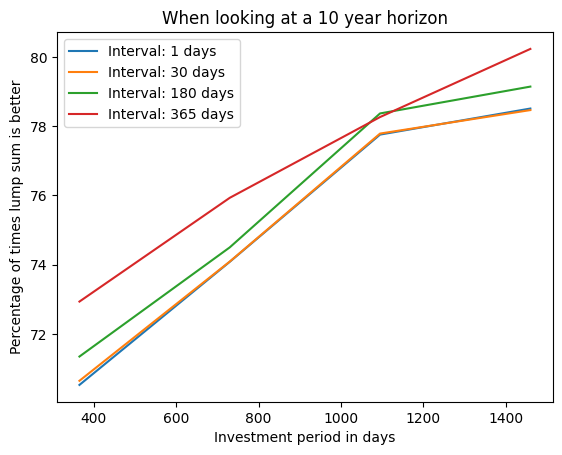

In [11]:
#plotting with looking at varying years, and a few interval times

numYearsToLookAt = 10
intervalTimes = [1, 30, 180, 365]
investmentPeriodInDays = [i*365 for i in range(1, 5)]

for interval in intervalTimes:
    percentageBetter = []
        
    for period in investmentPeriodInDays:

        percentage = compareLumpSumAndDca(numYearsToLookAt, interval, period)
        percentageBetter.append(percentage)
    
    plt.plot(investmentPeriodInDays, percentageBetter, label=f"Interval: {interval} days")

plt.title("When looking at a 10 year horizon")
plt.xlabel("Investment period in days")
plt.ylabel("Percentage of times lump sum is better")
plt.legend()
plt.savefig("lumpSumVsDca.png")
plt.show()

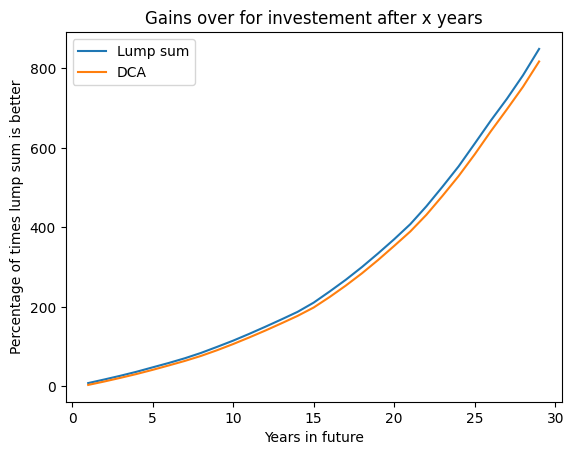

In [28]:
#comparing percentage gain

#take percentage gain difference -> lump sum vs dca (try both ways with calc)

numYearsToLookAt = [i for i in range(1, 30)]

intervalTimes = 30
investmentPeriodInDays = 365

percentageBetter = []
res1PercentageGainsArr = []
res2PercentageGainsArr = []
for year in numYearsToLookAt:
	res1, res2 = getRes1AndRes2(year, intervalTimes, investmentPeriodInDays)

	idx, initialValue, futureValue1 = res1[:,0], res1[:,1], res1[:,2]
	idx, investedAtMean, futureValue2 = res2[:,0], res2[:,1], res2[:,2]
    
	res1PercentageGain = (futureValue1 - initialValue)/initialValue*100
	res1PercentageGainsArr.append(np.mean(res1PercentageGain))
	res2PercentageGain = (futureValue2 - investedAtMean)/investedAtMean*100
	res2PercentageGainsArr.append(np.mean(res2PercentageGain))


plt.plot(numYearsToLookAt, res1PercentageGainsArr, label=f"Lump sum")
plt.plot(numYearsToLookAt, res2PercentageGainsArr, label=f"DCA")

plt.title("Gains over for investement after x years")
plt.xlabel("Years in future")
plt.ylabel("Percentage of times lump sum is better")
plt.legend()
plt.savefig("lumpSumVsDcaPercentageGains.png")
plt.show()

In [ ]:
#NOTE nå står det at lump alltid er bedre, det er fordi vi ser på avg over all tider (og avg så vil det være bedre siden det er bedre 70 prosent av tiden)